### Distribution map of COVID-19 cases in Ceará

The final map is intended to be submitted to wikidata item [Q90267612](https://www.wikidata.org/wiki/Q90267612).

The [original notebook](https://github.com/lubianat/covid_19_sandbox/blob/master/sao_paulo_covid/Map%20of%20Covid-19%20Cases%20in%20S%C3%A3o%20Paulo.ipynb) was made by Tiago Lubiana for São Paulo state, this is merely an adaption, so thank him!

In [1]:
import pandas as pd
from datetime import date,datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests

Thanks a lot to [André Campos](https://github.com/andreloc) for his workshop in Open Data Day - Fortaleza teaching how to use the Integrasus API, which I attended. The following code snippet is his creation.

In [2]:
def get_dataframe(api_url, id_municipio=''):    
    api_url = api_url + '?'
    if(id_municipio != ''): 
        api_url = '{}idMunicipio={}&'.format(api_url, id_municipio)
    
    result = requests.get(api_url)
    result = result.json()    
    result = pd.DataFrame.from_dict(result)
    
    if(id_municipio != ''): 
        result.insert(0, 'idMunicipio', id_municipio)
        
    return result

In [3]:
api_endpoint = "https://indicadores.integrasus.saude.ce.gov.br/api/coronavirus/qtd-por-dia-tipo"
qtd_por_municipios  = get_dataframe('https://indicadores.integrasus.saude.ce.gov.br/api/coronavirus/qtd-por-municipio')

In [4]:
qtd_por_municipios = qtd_por_municipios.query("tipo == 'Confirmado'")
qtd_por_municipios

,tipo,idMunicipio,qtdSuspeito,municipio,qtdObito,qtdConfirmado
191,Confirmado,230030.0,NaN,ACOPIARA,NaN,1.0
192,Confirmado,230075.0,NaN,AMONTADA,NaN,1.0
193,Confirmado,230100.0,NaN,AQUIRAZ,NaN,30.0
194,Confirmado,230110.0,NaN,ARACATI,NaN,3.0
195,Confirmado,230120.0,NaN,ARACOIABA,NaN,1.0
...,...,...,...,...,...,...
262,Confirmado,231330.0,NaN,TAUA,NaN,4.0
263,Confirmado,231340.0,NaN,TIANGUA,NaN,3.0
264,Confirmado,231350.0,NaN,TRAIRI,NaN,1.0
265,Confirmado,231400.0,NaN,VARZEA ALEGRE,NaN,1.0


In [5]:
np.sum(qtd_por_municipios['qtdConfirmado'])

2387.0

In [6]:
mapa_dos_municipios = gpd.read_file("../../estados_shapes/unzipped/23MUE250GC_SIR.shp")

In [7]:
mapa_dos_municipios.columns = ['municipio', 'idMunicipio', 'geometry']
mapa_dos_municipios.head()

,municipio,idMunicipio,geometry
0,ABAIARA,2300101,"POLYGON ((-38.97030 -7.42638, -38.97030 -7.426..."
1,ACARAPE,2300150,"POLYGON ((-38.61977 -4.16438, -38.61985 -4.169..."
2,ACARAÚ,2300200,"POLYGON ((-39.94349 -2.86047, -39.94722 -2.870..."
3,ACOPIARA,2300309,"POLYGON ((-39.05229 -6.02587, -39.05247 -6.038..."
4,AIUABA,2300408,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370..."


In [8]:
ce_conf = qtd_por_municipios.loc[:,['municipio', 'qtdConfirmado']]

In [9]:
mapa_dos_municipios['municipio'] = mapa_dos_municipios['municipio']
map_conf = pd.merge(mapa_dos_municipios, ce_conf, on='municipio', how='left')
map_conf

,municipio,idMunicipio,geometry,qtdConfirmado
0,ABAIARA,2300101,"POLYGON ((-38.97030 -7.42638, -38.97030 -7.426...",NaN
1,ACARAPE,2300150,"POLYGON ((-38.61977 -4.16438, -38.61985 -4.169...",NaN
2,ACARAÚ,2300200,"POLYGON ((-39.94349 -2.86047, -39.94722 -2.870...",NaN
3,ACOPIARA,2300309,"POLYGON ((-39.05229 -6.02587, -39.05247 -6.038...",1.0
4,AIUABA,2300408,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...",NaN
...,...,...,...,...
179,URUBURETAMA,2313807,"POLYGON ((-39.45588 -3.64239, -39.45588 -3.642...",NaN
180,URUOCA,2313906,"POLYGON ((-40.69245 -3.24248, -40.66954 -3.247...",NaN
181,VARJOTA,2313955,"POLYGON ((-40.43172 -4.09169, -40.43229 -4.093...",NaN
182,VÁRZEA ALEGRE,2314003,"POLYGON ((-39.10939 -6.71454, -39.10954 -6.715...",NaN


In [10]:
map_conf["qtdConfirmado"] = map_conf["qtdConfirmado"].fillna(0)

map_conf["casos_categorizados"] = pd.cut(map_conf["qtdConfirmado"],
                                                    bins = [-1,1, 10,50,500,1000, 100000000],
                                                   labels = ["0", "1-10", "11-50", "51-500","501-1000", ">1000"])


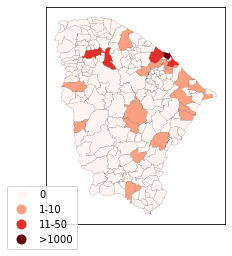

In [12]:
fig, ax = plt.subplots()
ax = map_conf.plot(column='casos_categorizados',
                         categorical=True, 
                         legend=True, 
                         figsize=(100,6),
                         markersize=46,
                         cmap = "Reds",
                         edgecolor='k',
                         linewidth=0.1,
                         ax=ax);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
plt.savefig("figs/casos_ce_" + "16_april" + ".png", dpi = 300)